# **The Learnable Typewriter** 📇

## A Generative Approach to Text Line Analysis

### [Yannis Siglidis](https://imagine.enpc.fr/~siglidii/), [Nicolas Gonthier](https://perso.telecom-paristech.fr/gonthier/), [Julien Gaubil](https://juliengaubil.github.io/), [Tom Monnier](https://www.tmonnier.com/), [Mathieu Aubry](http://imagine.enpc.fr/~aubrym/)  
### [Imagine](https://imagine.enpc.fr/), _LIGM, Ecole des Ponts, Univ Gustave Eiffel, CNRS, Marne-la-Vallée, France_

![teaser.png](https://raw.githubusercontent.com/ysig/learnable-typewriter/main/.media/teaser.png)

## Purpose ⭐
Here we provide a minimal notebook for performing inference with the [Learnable Typewriter](https://imagine.enpc.fr/~siglidii/learnable-typewriter/).  
A quick demo in paleography and additional inventive ways of using our software are the most probable future additions.

## Install 🌟

We first clone and install the dependencies of the learnable-typewriter repository (**requires restart**).

### Imports

In [3]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
from os.path import abspath, join
from IPython.display import display, display_markdown

import torch
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

CURRENT_DIR = os.path.abspath('')
PARENT = os.path.dirname(CURRENT_DIR)
#PARENT = abspath('')
RUNS = join(PARENT, "runs/")
sys.path.append(PARENT)

In [4]:
from learnable_typewriter.utils.loading import load_pretrained_model
from learnable_typewriter.data.dataloader import collate_fn_pad_to_max

## Inference💫

As inference we denote the production of the following information out of a given input $x$:
- Reconstruction
- Semantic Segmentation
- Labelling

### Helper functions

Using the `decompositor` module we can produce all the required reconstruction and semantic segmentation information.  
To just obtain reconstruction we can also use the `xp = model.predict_cell_per_cell(x)` function.  
Finally to infer the ground truth characters we use the `trainer.inference(x, xp)` module (where the second argument can be ommitted in the expense of recomputing it internally).

In [5]:
#separer la fonction qui trouve la ligne du dataset
def get_line(loader, idx):
    ds = loader[0].dataset[idx] #idx = the specific data sample you want to perform inference on
    x = collate_fn_pad_to_max([ds], supervised=True) # forms a batch of a single element
    return x

def inference_from_line(decompositor, x):
    obj = decompositor(x)
    #gt, rec, sgm = [to_pil_image(a.cpu()[0]) for a in [x['x'], obj['reconstruction'], obj['segmentation']]]
    rec = to_pil_image(obj['reconstruction'].cpu()[0])
    sgm = to_pil_image(obj['segmentation'].cpu()[0])
    x_image = to_pil_image(x['x'].cpu()[0])
    return x_image, rec, sgm

def inference(trainer, idx):
    ds = trainer.train_loader[0].dataset[idx] #idx = the specific data sample you want to perform inference on
    x = collate_fn_pad_to_max([ds], supervised=True) # forms a batch of a single element
    print(x.keys())

    obj = trainer.decompositor(x)
    gt, rec, sgm = [to_pil_image(a.cpu()[0]) for a in [x['x'], obj['reconstruction'], obj['segmentation']]]

    transcribe = trainer.transcribe_unsupervised if trainer.unsupervised else trainer.transcribe
    gt_txt, pred_txt = '', ''
    #''.join([trainer.transcribe_dataset[t] for t in x['y'][0]]), ''.join([transcribe[t] for t in trainer.inference(x, obj)[0]])
    return gt, rec, sgm, gt_txt, pred_txt

### We also plot the sprites of the model associated with the colors they have on the semantic segmentation. This can help us identify which sprite is being used and whether multiple sprites are overlayed.

In [6]:
def plot_colored_sprites(trainer, n_row=21, n_z=0):
    masks = trainer.model.masks

    colors = torch.Tensor(trainer.decompositor.colors)
    colors = colors.unsqueeze(-1).unsqueeze(-1)  #size (K,3,1,1)
    colors = 1 - colors.expand(masks.size()[0], 3, *masks.size()[2:]) #size (K,3,H_sprite,W_sprite)

    masks = (1 - colors*masks.expand(-1, 3, -1, -1))
    print(masks.shape)

    pad = n_z * [torch.ones_like(masks[0].unsqueeze(0))]
    masks = torch.cat([masks[i].unsqueeze(0) for i in range(masks.size()[0])] + pad, dim=0)
    return to_pil_image(make_grid(masks, nrow=n_row, padding_value=1, padding=2))

In [7]:
def plot_bnw_sprites(trainer, n_row=21, n_z=0):
    masks = trainer.model.masks

    # Reverse the colors of the masks
    reversed_masks = 1 - masks

    print(masks.shape)

    pad = n_z * [torch.ones_like(reversed_masks[0].unsqueeze(0))]
    masks = torch.cat([reversed_masks[i].unsqueeze(0) for i in range(reversed_masks.size()[0])] + pad, dim=0)
    return to_pil_image(make_grid(masks, nrow=n_row, padding_value=1, padding=2))

### Import document/script models

In [8]:
def display_sprites_from_model(model_path, color=True):
    trainer = load_pretrained_model(path=model_path, device=None)

    if color:
        display(plot_colored_sprites(trainer))
    else:
        display(plot_bnw_sprites(trainer))

{0: '.', 1: ':', 2: 'A', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'H', 8: 'I', 9: 'J', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'V', 20: 'a', 21: 'b', 22: 'c', 23: 'd', 24: 'e', 25: 'f', 26: 'g', 27: 'h', 28: 'i', 29: 'j', 30: 'l', 31: 'm', 32: 'n', 33: 'o', 34: 'p', 35: 'q', 36: 'r', 37: 's', 38: 't', 39: 'u', 40: 'x', 41: 'y', 42: 'Ñ', 43: 'ã', 44: 'ñ', 45: 'õ', 46: 'ĩ', 47: 'ũ', 48: '̃', 49: '̾', 50: 'ͣ', 51: 'ͤ', 52: 'ͥ', 53: 'ͦ', 54: 'ͬ', 55: '᷑', 56: 'ᷤ', 57: 'ẽ', 58: '⁊', 59: 'ꝑ', 60: 'ꝓ', 61: 'ꝙ', 62: 'ꝯ', 63: 'ꝰ', 64: 'ꝵ', 65: '\uf1ac'}
torch.Size([59, 1, 48, 48])


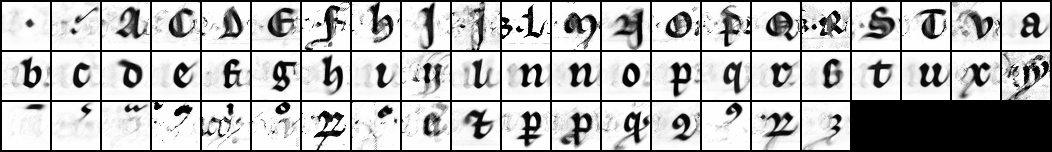

In [9]:
arras_path = join(RUNS, 'cremma_masks/arras-mask-0.1-3-test/2023-12-05_20-33-54')
display_sprites_from_model(arras_path, color=False)

In [11]:
arras_trainer = load_pretrained_model(path=arras_path, device=None)

{0: '.', 1: ':', 2: 'A', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'H', 8: 'I', 9: 'J', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'V', 20: 'a', 21: 'b', 22: 'c', 23: 'd', 24: 'e', 25: 'f', 26: 'g', 27: 'h', 28: 'i', 29: 'j', 30: 'l', 31: 'm', 32: 'n', 33: 'o', 34: 'p', 35: 'q', 36: 'r', 37: 's', 38: 't', 39: 'u', 40: 'x', 41: 'y', 42: 'Ñ', 43: 'ã', 44: 'ñ', 45: 'õ', 46: 'ĩ', 47: 'ũ', 48: '̃', 49: '̾', 50: 'ͣ', 51: 'ͤ', 52: 'ͥ', 53: 'ͦ', 54: 'ͬ', 55: '᷑', 56: 'ᷤ', 57: 'ẽ', 58: '⁊', 59: 'ꝑ', 60: 'ꝓ', 61: 'ꝙ', 62: 'ꝯ', 63: 'ꝰ', 64: 'ꝵ', 65: '\uf1ac'}


### Supervised

## Matenia 21/09

In [12]:
import matplotlib.pyplot as plt
import numpy as np
masks_arras = arras_trainer.model.masks

In [13]:
print("Shape:", masks_arras.shape) #64=nb de sprites, 1 channel(grayscale image), 48x48 dimensions
print("Data type:", masks_arras.dtype) #float32
print("Example:\n", masks_arras[0])

Shape: torch.Size([59, 1, 48, 48])
Data type: torch.float32
Example:
 tensor([[[2.1967e-03, 8.4179e-03, 1.3562e-03,  ..., 4.1366e-03,
          3.3243e-03, 3.4261e-03],
         [2.6193e-03, 2.4804e-03, 7.5815e-03,  ..., 3.9077e-03,
          3.6987e-03, 4.6287e-03],
         [1.2448e-03, 2.6868e-03, 9.6629e-03,  ..., 6.7109e-03,
          6.0057e-03, 6.2900e-03],
         ...,
         [1.1041e-04, 1.8268e-04, 2.9885e-04,  ..., 1.2730e-04,
          1.0261e-04, 6.5443e-05],
         [5.1148e-05, 1.1207e-04, 1.0207e-04,  ..., 6.7973e-05,
          6.1401e-05, 2.0519e-05],
         [2.7815e-04, 7.5944e-05, 9.4892e-05,  ..., 3.5892e-05,
          3.4144e-05, 2.3876e-05]]], grad_fn=<SelectBackward0>)


In [24]:
a_arras = masks_arras[22].squeeze().detach().cpu().numpy()  # Convert to a NumPy array
#a_sbb = masks_sbb[23].squeeze().detach().cpu().numpy()
#a_wett = masks_wett[32].squeeze().detach().cpu().numpy()
#a_textualis = masks_textualis[33].squeeze().detach().cpu().numpy()
#a_textualis = masks_textualis[33].squeeze().detach().cpu().numpy()

In [25]:
d_arras = masks_arras[25].squeeze().detach().cpu().numpy()  # Convert to a NumPy array
d_sbb = masks_sbb[26].squeeze().detach().cpu().numpy()
d_wett = masks_wett[35].squeeze().detach().cpu().numpy()
d_textualis = masks_textualis[36].squeeze().detach().cpu().numpy()

#d_textualis = masks_textualis[33].squeeze().detach().cpu().numpy()

In [26]:
g_arras = masks_arras[28].squeeze().detach().cpu().numpy()  # Convert to a NumPy array
g_sbb = masks_sbb[29].squeeze().detach().cpu().numpy()
g_wett = masks_wett[38].squeeze().detach().cpu().numpy()
g_textualis = masks_textualis[39].squeeze().detach().cpu().numpy()

#d_textualis = masks_textualis[33].squeeze().detach().cpu().numpy()

In [27]:
print("Shape:", a_arras.shape) #48x48 dimensions image, 1 channel
print("Data type:", a_arras.dtype) #float32
print("Example:\n", a_arras)

Shape: (48, 48)
Data type: float32
Example:
 [[3.4728355e-04 2.4282643e-04 2.8269470e-04 ... 1.7761382e-04
  2.7108224e-04 3.1094826e-04]
 [4.9608841e-04 3.7756306e-04 3.4677819e-04 ... 2.3849531e-04
  5.5092084e-04 3.9905615e-04]
 [7.6284149e-04 7.2184240e-04 6.5068383e-04 ... 2.7907838e-04
  3.3342082e-04 4.1234464e-04]
 ...
 [1.6956339e-05 2.1515651e-04 2.1319670e-04 ... 1.3647408e-05
  1.4658661e-05 2.7523325e-05]
 [1.7973744e-04 1.9260947e-04 2.5251202e-04 ... 1.1029273e-05
  1.3231439e-05 1.2457922e-05]
 [1.9119472e-04 2.3850056e-04 2.7994768e-04 ... 1.4372207e-05
  2.1804306e-05 1.7916349e-05]]


In [28]:
print("Shape:", masks_textualis.shape) #92=nb de sprites, 1 channel(grayscale image), 48x48 dimensions
print("Data type:", masks_textualis.dtype) #float32
print("Example:\n", masks_textualis[0])

Shape: torch.Size([92, 1, 48, 48])
Data type: torch.float32
Example:
 tensor([[[0.9642, 0.9207, 0.9496,  ..., 0.9999, 1.0000, 0.9997],
         [0.7182, 0.9979, 0.9988,  ..., 0.9999, 0.9999, 0.9998],
         [0.0381, 0.9965, 0.9854,  ..., 0.9997, 0.9993, 0.9993],
         ...,
         [0.9441, 0.9178, 0.9876,  ..., 0.9999, 1.0000, 0.9999],
         [0.8425, 0.9809, 0.9932,  ..., 0.9999, 0.9999, 0.9999],
         [0.4398, 0.6415, 0.9794,  ..., 0.9999, 0.9999, 0.9999]]],
       grad_fn=<SelectBackward0>)


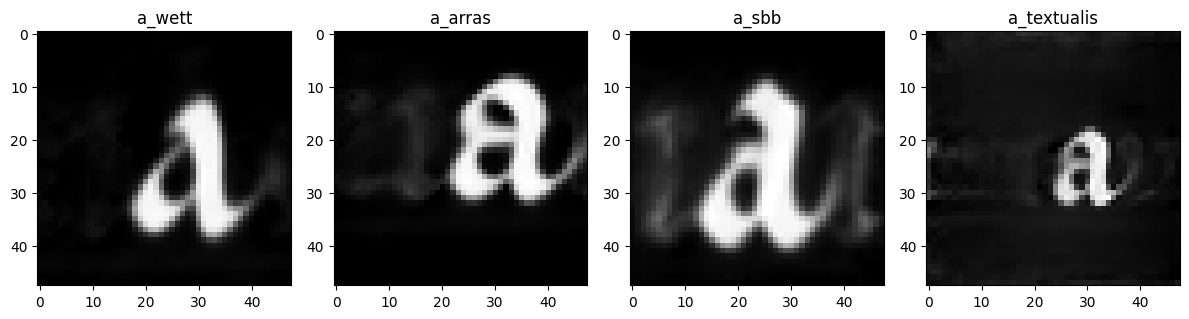

In [29]:
from skimage.transform import resize
import cv2

fig, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].imshow(a_wett, cmap='gray')
ax[0].set_title('a_wett')
ax[1].imshow(a_arras, cmap='gray')
ax[1].set_title('a_arras')
ax[2].imshow(a_sbb, cmap='gray')
ax[2].set_title('a_sbb')
ax[3].imshow(a_textualis, cmap='gray')
ax[3].set_title('a_textualis')


# Show the plot
plt.tight_layout()

plt.show()

#Aarau. Aargauer Kantonsbibliothek, MsWettF 15 - 1270-1280 
#Arras. Médiathèque municipale, Ms. 861 - 1300-1399
#Berlin, Stundenbuch, Hdschr. 25 - 1400-1499
   
    
    

Text(0.5, 1.0, 'Colored overlay wett/sbb')

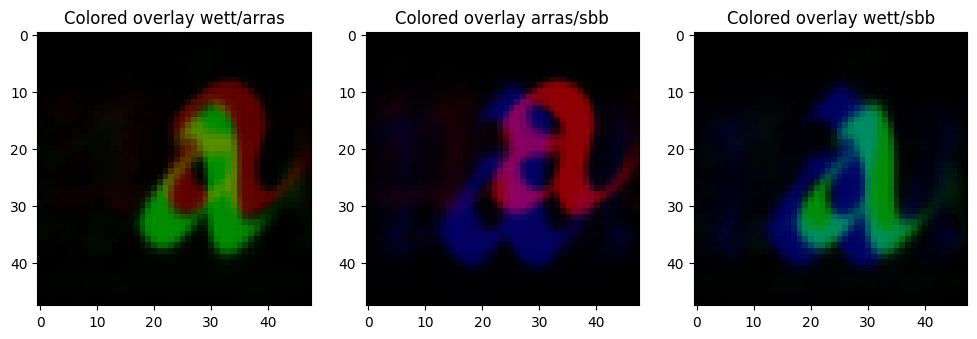

In [30]:
import numpy as np

# Assuming a_arras, a_wett, and a_sbb are your grayscale NumPy arrays with shape (48, 48)

# Add a new axis to create a single-channel (grayscale) image with shape (48, 48, 1)
a_arras_colored = a_arras[:, :, np.newaxis]
a_wett_colored = a_wett[:, :, np.newaxis]
a_sbb_colored = a_sbb[:, :, np.newaxis]

# Stack the single-channel images to create RGB images
a_arras_colored = np.concatenate((a_arras_colored, np.zeros_like(a_arras_colored), np.zeros_like(a_arras_colored)), axis=-1)  # Red
a_wett_colored = np.concatenate((np.zeros_like(a_wett_colored), a_wett_colored, np.zeros_like(a_wett_colored)), axis=-1)  # Green
a_sbb_colored = np.concatenate((np.zeros_like(a_sbb_colored), np.zeros_like(a_sbb_colored), a_sbb_colored), axis=-1)  # Blue

def overlay_images(image1, image2, opacity):
    """
    Overlay two RGB images with a specified opacity.

    Args:
        image1 (numpy.ndarray): The first RGB image.
        image2 (numpy.ndarray): The second RGB image.
        opacity (float): Opacity value between 0.0 (completely transparent) and 1.0 (completely opaque).

    Returns:
        numpy.ndarray: The overlay result.
    """
    return cv2.addWeighted(image1, 1 - opacity, image2, opacity, 0)


fig, ax = plt.subplots(1, 3, figsize=(12, 4))

opacity = 0.4

ax[0].imshow(overlay_images(a_wett_colored, a_arras_colored, opacity))
ax[0].set_title('Colored overlay wett/arras')

ax[1].imshow(overlay_images(a_arras_colored, a_sbb_colored, opacity))
ax[1].set_title('Colored overlay arras/sbb')

ax[2].imshow(overlay_images(a_wett_colored,a_sbb_colored, opacity))
ax[2].set_title('Colored overlay wett/sbb')

In [31]:
def calculate_image_distance(image1, image2):
    """
    Calculate the L2 (Euclidean) distance between two images.

    Args:
        image1 (numpy.ndarray): The first image.
        image2 (numpy.ndarray): The second image.

    Returns:
        float: The L2 distance between the two images.
    """
    difference = np.abs(image1 - image2)
    l2_norm_difference = np.linalg.norm(difference)
    return l2_norm_difference

In [32]:
# Example usage
distance_wett_arras_a = calculate_image_distance(a_wett, a_arras)
distance_arras_sbb_a = calculate_image_distance(a_arras, a_sbb)
distance_wett_sbb_a = calculate_image_distance(a_wett, a_sbb)

distance_textualis_arras_a = calculate_image_distance(a_textualis, a_arras)
distance_textualis_wett_a = calculate_image_distance(a_textualis, a_wett)
distance_textualis_sbb_a = calculate_image_distance(a_textualis, a_sbb)

# Create subplots for visualizing the distances
#fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Visualize the distances
#axs[0].imshow(np.abs(a_arras - a_wett), cmap=plt.cm.viridis, norm=plt.Normalize(0, 1))
#axs[0].set_title(f"L2 Norm of Difference wett/arras : {distance_wett_arras_a:.2f}")

#axs[1].imshow(np.abs(a_arras - a_sbb), cmap=plt.cm.viridis, norm=plt.Normalize(0, 1))
#axs[1].set_title(f"L2 Norm of Difference arras/sbb: {distance_arras_sbb_a:.2f}")

#axs[2].imshow(np.abs(a_sbb - a_wett), cmap=plt.cm.viridis, norm=plt.Normalize(0, 1))
#axs[2].set_title(f"L2 Norm of Difference wett/sbb: {distance_wett_sbb_a:.2f}")

# Adjust spacing between subplots
#plt.tight_layout()

# Show the figure
#plt.show()

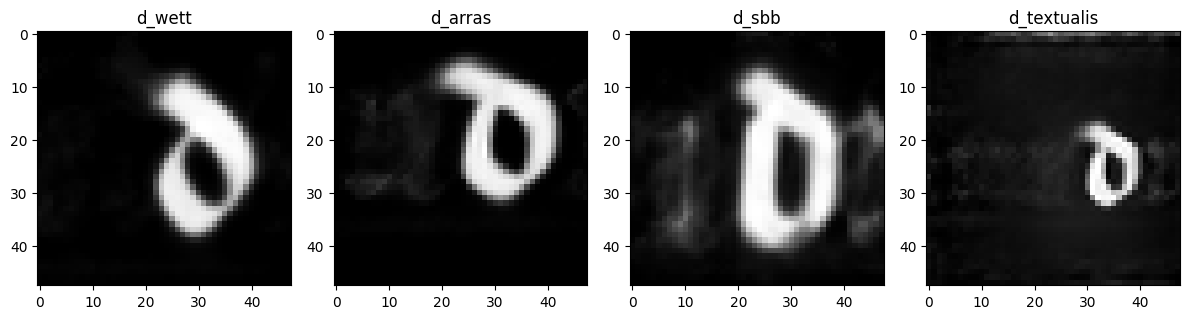

In [33]:

fig, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].imshow(d_wett, cmap='gray')
ax[0].set_title('d_wett')
ax[1].imshow(d_arras, cmap='gray')
ax[1].set_title('d_arras')
ax[2].imshow(d_sbb, cmap='gray')
ax[2].set_title('d_sbb')
ax[3].imshow(d_textualis, cmap='gray')
ax[3].set_title('d_textualis')


# Show the plot
plt.tight_layout()

plt.show()

#Aarau. Aargauer Kantonsbibliothek, MsWettF 15 - 1270-1280 
#Arras. Médiathèque municipale, Ms. 861 - 1300-1399
#Berlin, Stundenbuch, Hdschr. 25 - 1400-1499

In [34]:
# Example usage
distance_wett_arras_d = calculate_image_distance(d_wett, d_arras)
distance_arras_sbb_d = calculate_image_distance(d_arras, d_sbb)
distance_wett_sbb_d = calculate_image_distance(d_wett, d_sbb)

distance_textualis_arras_d = calculate_image_distance(d_textualis, d_arras)
distance_textualis_wett_d = calculate_image_distance(d_textualis, d_wett)
distance_textualis_sbb_d = calculate_image_distance(d_textualis, d_sbb)

# Create subplots for visualizing the distances
#fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Visualize the distances
#axs[0].imshow(np.abs(d_arras - d_wett), cmap=plt.cm.viridis, norm=plt.Normalize(0, 1))
#axs[0].set_title(f"L2 Norm of Difference wett/arras : {distance_wett_arras_d:.2f}")

#axs[1].imshow(np.abs(d_arras - d_sbb), cmap=plt.cm.viridis, norm=plt.Normalize(0, 1))
#axs[1].set_title(f"L2 Norm of Difference arras/sbb: {distance_arras_sbb_d:.2f}")

#axs[2].imshow(np.abs(d_sbb - d_wett), cmap=plt.cm.viridis, norm=plt.Normalize(0, 1))
#axs[2].set_title(f"L2 Norm of Difference wett/sbb: {distance_wett_sbb_d:.2f}")

# Adjust spacing between subplots
#plt.tight_layout()

# Show the figure
#plt.show()

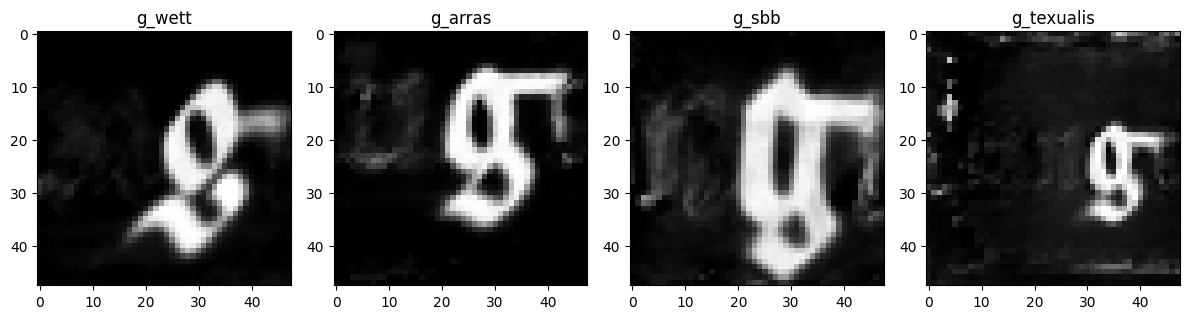

In [35]:
from skimage.transform import resize
import cv2

fig, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].imshow(g_wett, cmap='gray')
ax[0].set_title('g_wett')
ax[1].imshow(g_arras, cmap='gray')
ax[1].set_title('g_arras')
ax[2].imshow(g_sbb, cmap='gray')
ax[2].set_title('g_sbb')
ax[3].imshow(g_textualis, cmap='gray')
ax[3].set_title('g_texualis')


# Show the plot
plt.tight_layout()

plt.show()

#Aarau. Aargauer Kantonsbibliothek, MsWettF 15 - 1270-1280 
#Arras. Médiathèque municipale, Ms. 861 - 1300-1399
#Berlin, Stundenbuch, Hdschr. 25 - 1400-1499

In [36]:
# Example usage
distance_wett_arras_g = calculate_image_distance(g_wett, g_arras)
distance_arras_sbb_g = calculate_image_distance(g_arras, g_sbb)
distance_wett_sbb_g = calculate_image_distance(g_wett, g_sbb)

distance_textualis_arras_g = calculate_image_distance(g_textualis, g_arras)
distance_textualis_wett_g = calculate_image_distance(g_textualis, g_wett)
distance_textualis_sbb_g = calculate_image_distance(g_textualis, g_sbb)

# Create subplots for visualizing the distances
#fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Visualize the distances
#axs[0].imshow(np.abs(g_arras - g_wett), cmap=plt.cm.viridis, norm=plt.Normalize(0, 1))
#axs[0].set_title(f"L2 Norm of Difference wett/arras : {distance_wett_arras_g:.2f}")

#axs[1].imshow(np.abs(g_arras - g_sbb), cmap=plt.cm.viridis, norm=plt.Normalize(0, 1))
#axs[1].set_title(f"L2 Norm of Difference arras/sbb: {distance_arras_sbb_g:.2f}")

#axs[2].imshow(np.abs(g_sbb - g_wett), cmap=plt.cm.viridis, norm=plt.Normalize(0, 1))
#axs[2].set_title(f"L2 Norm of Difference wett/sbb: {distance_wett_sbb_g:.2f}")

# Adjust spacing between subplots
#plt.tight_layout()

# Show the figure
#plt.show()

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Your calculated distances
distances_a = [distance_textualis_arras_a, distance_textualis_wett_a, distance_textualis_sbb_a]
distances_d = [distance_textualis_arras_d, distance_textualis_wett_d, distance_textualis_sbb_d]
distances_g = [distance_textualis_arras_g, distance_textualis_wett_g, distance_textualis_sbb_g]

# Manuscripts
manuscripts = ['Arras', 'Wett', 'SBB']

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the distances for 'a'
ax.scatter(distances_a, [1] * len(distances_a), zs=manuscripts, label='Distance for A')

# Plot the distances for 'd'
ax.scatter(distances_d, [2] * len(distances_d), zs=manuscripts, label='Distance for D')

# Plot the distances for 'g'
ax.scatter(distances_g, [3] * len(distances_g), zs=manuscripts, label='Distance for G')

# Customize the plot
ax.set_xlabel('Distance')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['A', 'D', 'G'])
ax.set_zlabel('Manuscripts')
ax.set_title('Distances from Textualis')

# Show the plot
plt.legend()
plt.show()

ValueError: could not convert string to float: 'Arras'

Error in callback <function _draw_all_if_interactive at 0x7f7c06e530a0> (for post_execute):


ValueError: data type must provide an itemsize

ValueError: data type must provide an itemsize

<Figure size 1000x800 with 1 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your calculated distances
distances_a = [distance_textualis_arras_a, distance_textualis_wett_a, distance_textualis_sbb_a]
distances_d = [distance_textualis_arras_d, distance_textualis_wett_d, distance_textualis_sbb_d]
distances_g = [distance_textualis_arras_g, distance_textualis_wett_g, distance_textualis_sbb_g]

# Manuscripts
manuscripts = ['Arras', 'Wett', 'SBB']

# Number of manuscripts
num_manuscripts = len(manuscripts)

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(polar=True))

# Plot radar chart for each letter
for ax, distances, letter in zip(axs, [distances_a, distances_d, distances_g], ['A', 'D', 'G']):
    angles = np.linspace(0, 2 * np.pi, num_manuscripts, endpoint=False).tolist()
    angles += angles[:1]


    distances += distances[:1]

    ax.plot(angles, distances, linewidth=2, linestyle='solid', marker='o', label='Distances')
    ax.fill(angles, distances, alpha=0.4)

    ax.set_yticklabels([])
    ax.set_thetagrids(np.degrees(angles), manuscripts)
    ax.set_title(f'Distances for Letter {letter}')

# Display the legend outside the subplots
fig.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list of colors for each point
colors = ['red', 'green', 'blue']

# Create a new figure with two subplots arranged side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# Define the image names for labeling the points
image_names = ["a_wett", "a_sbb", "a_arras"]

# Plot the points with distances as coordinates in the first subplot
ax1.scatter([distance_wett_arras_a, distance_arras_sbb_a, distance_wett_sbb_a],
            [distance_arras_sbb_a, distance_wett_sbb_a, distance_wett_arras_a], c=colors, s=100, alpha=0.7)

# Annotate the points with image names in the first subplot
for name, x, y in zip(image_names, [distance_wett_arras_a, distance_arras_sbb_a, distance_wett_sbb_a], [distance_arras_sbb_a, distance_wett_sbb_a, distance_wett_arras_a]):
    ax1.annotate(name, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Add labels and title to the first subplot
ax1.set_xlabel('Distance: a_wett vs. a_arras / a_arras vs. a_sbb / a_wett vs. a_sbb')
ax1.set_ylabel('Distance: a_arras vs. a_sbb / a_wett vs. a_sbb / a_wett vs. a_arras')
ax1.set_title('Visualization of Image Distances ("a")')
ax1.grid()

# Define the image names for labeling the points in the second subplot
image_names_2 = ["d_wett", "d_sbb", "d_arras"]

# Plot the points with distances as coordinates in the second subplot
ax2.scatter([distance_wett_arras_d, distance_arras_sbb_d, distance_wett_sbb_d],
            [distance_arras_sbb_d, distance_wett_sbb_d, distance_wett_arras_d], c=colors, s=100, alpha=0.7)

# Annotate the points with image names in the second subplot
for name, x, y in zip(image_names_2, [distance_wett_arras_d, distance_arras_sbb_d, distance_wett_sbb_d], [distance_arras_sbb_d, distance_wett_sbb_d, distance_wett_arras_d]):
    ax2.annotate(name, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Add labels and title to the second subplot
ax2.set_xlabel('Distance: wett vs. arras / arras vs. sbb / wett vs. sbb')
ax2.set_ylabel('Distance: arras vs. sbb / wett vs. sbb / wett vs. arras')
ax2.set_title('Visualization of Image Distances ("d")')
ax2.grid()

# Define the image names for labeling the points in the second subplot
image_names_3 = ["g_wett", "g_sbb", "g_arras"]

# Plot the points with distances as coordinates in the second subplot
ax3.scatter([distance_wett_arras_g, distance_arras_sbb_g, distance_wett_sbb_g],
            [distance_arras_sbb_g, distance_wett_sbb_g, distance_wett_arras_g], c=colors, s=100, alpha=0.7)

# Annotate the points with image names in the second subplot
for name, x, y in zip(image_names_3, [distance_wett_arras_g, distance_arras_sbb_g, distance_wett_sbb_g], [distance_arras_sbb_g, distance_wett_sbb_g, distance_wett_arras_g]):
    ax3.annotate(name, (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Add labels and title to the second subplot
ax3.set_xlabel('Distance: wett vs. arras / arras vs. sbb / wett vs. sbb')
ax3.set_ylabel('Distance: arras vs. sbb / wett vs. sbb / wett vs. arras')
ax3.set_title('Visualization of Image Distances ("g")')
ax3.grid()


# Adjust spacing between subplots
plt.tight_layout()

# Show the figure with both subplots
plt.show()

In [ ]:
# Define the letters and manuscripts
letters = ['a', 'd', 'g']
manuscripts = ['wett', 'arras', 'sbb']

# Create a dictionary to store the distances for each letter
distances = {}

# Fill the distances dictionary with your data
for letter in letters:
    distances[letter] = [
        globals()[f'distance_wett_arras_{letter}'],
        globals()[f'distance_arras_sbb_{letter}'],
        globals()[f'distance_wett_sbb_{letter}']
    ]

# Transpose the distances dictionary for plotting
distances = {manuscript: [distances[letter][i] for letter in letters] for i, manuscript in enumerate(manuscripts)}

# Create subplots for the grouped bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define the colors for each manuscript
colors = {'wett': 'red', 'arras': 'green', 'sbb': 'blue'}

# Width of each bar
bar_width = 0.2

# Create positions for the bars
positions = np.arange(len(manuscripts))

# Plot the grouped bars for each manuscript
for i, (manuscript, distance_values) in enumerate(distances.items()):
    ax.bar(positions + i * bar_width, distance_values, bar_width, label=manuscript, color=colors[manuscript])

# Set x-axis labels and title
ax.set_xticks(positions + (bar_width * 1.5))
ax.set_xticklabels(letters)
ax.set_xlabel('Letters')
ax.set_ylabel('Distances')
ax.set_title('Distances between Manuscripts for Letters a, d, and g')

# Add a legend
ax.legend(title='Manuscripts')

# Show the figure
plt.tight_layout()
plt.show()

In [ ]:
# Create a list of colors for each point
colors = ['red', 'green', 'blue']

# Create a new figure
plt.figure(figsize=(8, 6))

# Define the image names for labeling the points
image_names = ["a_wett", "a_sbb", "a_arras"]
image_names_2 = ["d_wett", "d_sbb", "d_arras"]
image_names_3 = ["g_wett", "g_sbb", "g_arras"]

# Create lists for the distances
distances_1 = [distance_wett_arras_a, distance_arras_sbb_a, distance_wett_sbb_a]
distances_2 = [distance_wett_arras_d, distance_arras_sbb_d, distance_wett_sbb_d]
distances_3 = [distance_wett_arras_g, distance_arras_sbb_g, distance_wett_sbb_g]

# Plot the points with distances as coordinates
for i in range(3):
    plt.scatter([distances_1[i], distances_2[i], distances_3[i]],
                [distances_2[i], distances_1[i], distances_3[i]], c=colors[i], s=100, alpha=0.7)
    
    plt.annotate(image_names[i], (distances_1[i], distances_2[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.annotate(image_names_2[i], (distances_2[i], distances_1[i]), textcoords="offset points", xytext=(0, -20), ha='center')
    plt.annotate(image_names_3[i], (distances_3[i], distances_3[i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Add labels and title
plt.xlabel('Distance: (a_wett vs. a_arras / d_wett vs. d_arras / g_wett vs. g_arras)')
plt.ylabel('Distance: (a_arras vs. a_sbb / d_arras vs. d_sbb / g_arras vs. g_sbb)')
plt.title('Visualization of Individual Letter Distances')
plt.grid()

# Show the plot
plt.show()

### Line Reconstructions

In [52]:
from learnable_typewriter.typewriter.model import LearnableTypewriter
from learnable_typewriter.typewriter.inference import InferenceSupervised
from learnable_typewriter.typewriter.optim.loss import Loss
from learnable_typewriter.evaluate.qualitative.decompositor import Decompositor

In [53]:
wett_arras_loader = wett_arras_trainer.train_loader
wett_arras_decompositor = wett_arras_trainer.decompositor

In [56]:
fr95_trainer = load_pretrained_model(fr95_path, device=None)

{0: '.', 1: 'A', 2: 'C', 3: 'E', 4: 'J', 5: 'L', 6: 'M', 7: 'S', 8: 'a', 9: 'b', 10: 'c', 11: 'd', 12: 'e', 13: 'f', 14: 'g', 15: 'h', 16: 'i', 17: 'j', 18: 'l', 19: 'm', 20: 'n', 21: 'o', 22: 'p', 23: 'q', 24: 'r', 25: 's', 26: 't', 27: 'u', 28: 'v', 29: 'x', 30: 'z', 31: 'õ', 32: 'ͫ', 33: 'ẽ', 34: 'ꝑ'}


In [57]:
fr95_loader = fr95_trainer.train_loader
fr95_decompositor = fr95_trainer.decompositor

In [10]:
from IPython.display import display

def perform_inference_on_dataset(loader, decompositor):
    for idx in range(len(loader[0].dataset)):
        # Get a line from the dataset
        x = get_line(loader, idx)
        print(x.shape())
        
        # Perform inference on the line
        x_image, rec, sgm = inference_from_line(decompositor, x)
        
        # Display the results in the notebook
        print(f"Sample {idx} - Original Image:")
        display(x_image)

        print(f"Sample {idx} - Reconstructed Image:")
        display(rec)

        print(f"Sample {idx} - Segmentation Image:")
        display(sgm)

In [60]:
perform_inference_on_dataset(wett_arras_loader, wett_arras_decompositor)

RuntimeError: The expanded size of the tensor (94) must match the existing size (96) at non-singleton dimension 3.  Target sizes: [1, 1, 96, 94].  Tensor sizes: [96, 96]

In [28]:
import copy
import torch

class Sprites(torch.nn.Module):
    def __init__(self, proto, latents):
        super().__init__()
        self.proto = proto
        self.latents = latents

    def forward(self):
        return self.proto

    def flat_latents(self):
        return self.latents

def invert_dict(d):
    return dict((v, i) for i, v in d.items())

def extract_uc(trainer):
    return dict((c, i) for i, c in enumerate(trainer.train_loader[0].dataset.factoring[1]))

def sprite_swap(trainer_from, trainer_to):
    trainer_to = copy.deepcopy(trainer_to)
    sprites_to = trainer_to.model.masks
    sprites_from = trainer_from.model.masks
    latents = trainer_to.model.sprites.masks_.flat_latents()
    tod, fromd = extract_uc(trainer_to), extract_uc(trainer_from)

    for c, i in tod.items():
        if c in fromd:
            sprites_to[i] = sprites_from[fromd[c]]            

    trainer_to.model.sprites.masks_ = Sprites(sprites_to, latents)
    return trainer_to

In [31]:
index = 10

In [32]:
from IPython.display import display, Markdown

arras_loader = trainer_arras.train_loader
wett_loader = trainer_wett.train_loader
sbb_loader = trainer_sbb.train_loader

x_arras = get_line(arras_loader, index)
x_wett = get_line(wett_loader, index)
x_sbb = get_line(sbb_loader, index)

########  inference with proper models #####

arras_decompositor = trainer_arras.decompositor
gt_arras, rec_arras, sgm_arras = inference_from_line(arras_decompositor, x_arras)

wett_decompositor = trainer_wett.decompositor
gt_wett, rec_wett, sgm_wett = inference_from_line(wett_decompositor, x_wett)

sbb_decompositor = trainer_sbb.decompositor
gt_sbb, rec_sbb, sgm_sbb = inference_from_line(sbb_decompositor, x_sbb)

###### swap sprites ######
#wett with arras
trainer_wett_swap_arras = sprite_swap(trainer_arras, trainer_wett)
wett_decompositor_arras = trainer_wett_swap_arras.decompositor

#arras with wett
trainer_arras_swap_wett = sprite_swap(trainer_wett, trainer_arras)
arras_decompositor_wett = trainer_arras_swap_wett.decompositor

#wett with sbb
trainer_wett_swap_sbb = sprite_swap(trainer_sbb, trainer_wett)
wett_decompositor_sbb = trainer_wett_swap_sbb.decompositor

#arras with sbb
trainer_arras_swap_sbb = sprite_swap(trainer_sbb, trainer_arras)
arras_decompositor_sbb = trainer_arras_swap_sbb.decompositor

#sbb with arras
trainer_sbb_swap_arras = sprite_swap(trainer_arras, trainer_sbb)
sbb_decompositor_arras = trainer_sbb_swap_arras.decompositor

#sbb with wett
trainer_sbb_swap_wett = sprite_swap(trainer_wett, trainer_sbb)
sbb_decompositor_wett = trainer_sbb_swap_wett.decompositor

##### perform inference with swapped models #####

gt_arras_wett, rec_arras_wett, sgm_arras_wett = inference_from_line(wett_decompositor_arras, x_arras)
gt_wett_arras, rec_wett_arras, sgm_wett_arras = inference_from_line(arras_decompositor_wett, x_wett)

gt_sbb_arras, rec_sbb_arras, sgm_sbb_arras = inference_from_line(sbb_decompositor_arras, x_sbb)
gt_sbb_wett, rec_sbb_wett, sgm_sbb_wett = inference_from_line(sbb_decompositor_wett, x_wett)

gt_arras_sbb, rec_arras_sbb, sgm_arras_sbb = inference_from_line(arras_decompositor_sbb, x_arras)
gt_sbb_arras, rec_arras_sbb, sgm_arras_sbb = inference_from_line(sbb_decompositor_arras, x_sbb)


<font size="4">**Ground Truth Image (gt_arras):**

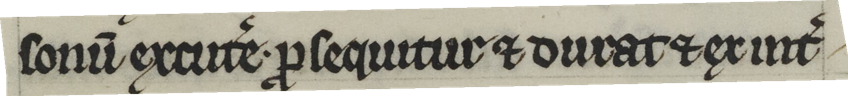

<font size="4">**Reconstruction from standard model (rec_arras) with arras sprites:**

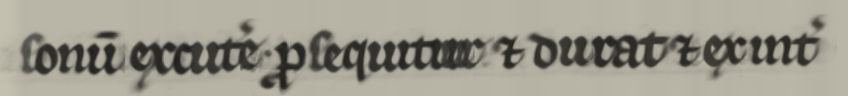

<font size="4">**Reconstruction from wett model (rec_arras_wett) with arras sprites:**

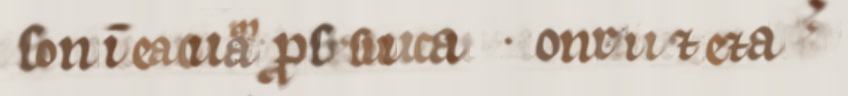

<font size="4">**Reconstruction from sbb model (rec_arras_sbb) with arras sprites:**

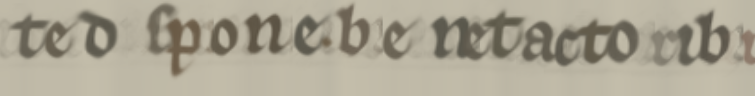

<font size="4">**Segmentation from standard model (sgm_arras) with arras sprites:**

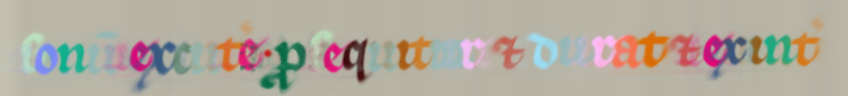

<font size="4">**Segmentation from wett model (sgm_arras_wett) with arras sprites:**

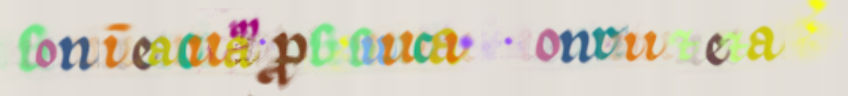

<font size="4">**Segmentation from sbb model (sgm_arras_sbb) with arras sprites:**

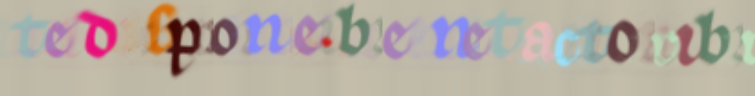

In [33]:
display(Markdown('<font size="4">**Ground Truth Image (gt_arras):**'))
display(gt_arras)
display(Markdown('<font size="4">**Reconstruction from standard model (rec_arras) with arras sprites:**'))
display(rec_arras)
display(Markdown('<font size="4">**Reconstruction from wett model (rec_arras_wett) with arras sprites:**'))
display(rec_arras_wett)
display(Markdown('<font size="4">**Reconstruction from sbb model (rec_arras_sbb) with arras sprites:**'))
display(rec_arras_sbb)
display(Markdown('<font size="4">**Segmentation from standard model (sgm_arras) with arras sprites:**'))
display(sgm_arras)
display(Markdown('<font size="4">**Segmentation from wett model (sgm_arras_wett) with arras sprites:**'))
display(sgm_arras_wett)
display(Markdown('<font size="4">**Segmentation from sbb model (sgm_arras_sbb) with arras sprites:**'))
display(sgm_arras_sbb)

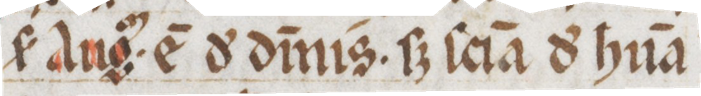

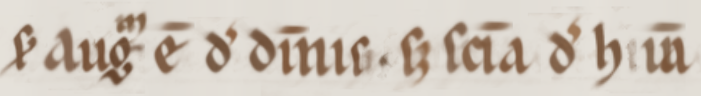

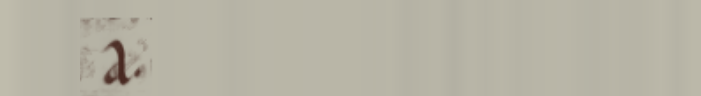

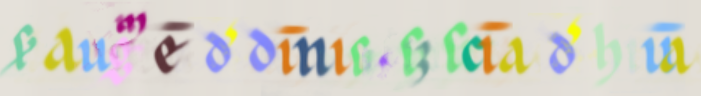

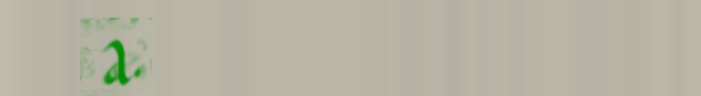

In [34]:
display(gt_wett)
display(rec_wett)
display(rec_wett_arras)
display(sgm_wett)
display(sgm_wett_arras)

In [35]:
import numpy as np
from PIL import Image

def calculate_l2_loss(gt_image, reconstruction_image):
    """
    Calculate the L2 loss between a ground truth (gt) image and a reconstruction image.
    
    Parameters:
        gt_image (PIL.Image.Image): The ground truth image.
        reconstruction_image (PIL.Image.Image): The reconstruction image.
    
    Returns:
        float: The L2 loss between the two images.
    """
    # Convert Pillow images to NumPy arrays
    gt_array = np.array(gt_image)
    reconstruction_array = np.array(reconstruction_image)

    # Convert the images to RGBA format if they are not already
    if gt_array.shape[-1] != 4:
        gt_array = np.dstack((gt_array, np.full(gt_array.shape[:-1], 255, dtype=np.uint8)))

    if reconstruction_array.shape[-1] != 4:
        reconstruction_array = np.dstack((reconstruction_array, np.full(reconstruction_array.shape[:-1], 255, dtype=np.uint8)))

    # Calculate the L2 error
    l2_error = np.mean((reconstruction_array - gt_array) ** 2)

    return l2_error

In [36]:
l2_error_arras = calculate_l2_loss(gt_arras, rec_arras)
print(l2_error_arras)
l2_error_arras_wett = calculate_l2_loss(gt_arras, rec_arras_wett)
print(l2_error_arras_wett)

70.88188814367139
86.10009458529875


In [37]:
l2_error_wett = calculate_l2_loss(gt_wett, rec_wett)
print(l2_error_wett)
l2_error_wett_arras = calculate_l2_loss(gt_wett, rec_wett_arras)
print(l2_error_wett_arras)

53.82354820494532
93.54902223014741


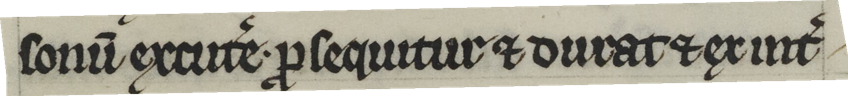

<font size="4">**Segmentation from arras model with custon background constant**

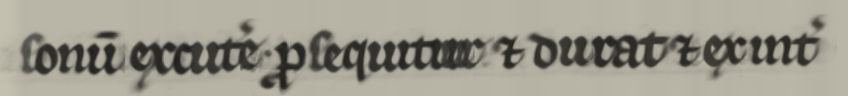

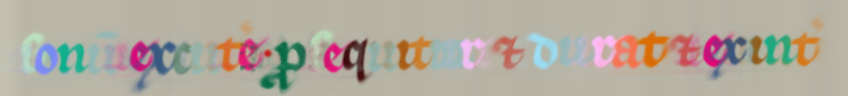

<font size="4">**Segmentation from arras model with 0.5/0.5/0.5 background constant**

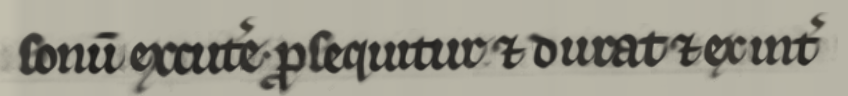

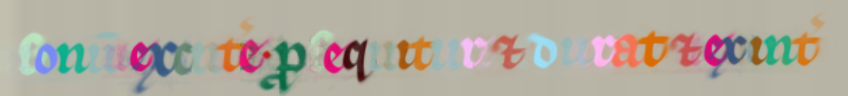

In [38]:
arras_05_bg_loader = trainer_arras_05_bg.train_loader
x_arras_05_bg = get_line(arras_05_bg_loader, index)
arras_05_bg_decompositor = trainer_arras_05_bg.decompositor
gt_arras_05_bg, rec_arras_05_bg, sgm_arras_05_bg = inference_from_line(arras_05_bg_decompositor, x_arras_05_bg)

display(gt_arras)
display(Markdown('<font size="4">**Segmentation from arras model with custon background constant**'))
display(rec_arras)
display(sgm_arras)
display(Markdown('<font size="4">**Segmentation from arras model with 0.5/0.5/0.5 background constant**'))
display(rec_arras_05_bg)
sbb_05_bg_loader = trainer_sbb_05_bg.train_loader
x_sbb_05_bg = get_line(sbb_05_bg_loader, index)
sbb_05_bg_decompositor = trainer_sbb_05_bg.decompositor
gt_sbb_05_bg, rec_sbb_05_bg, sgm_sbb_05_bg = inference_from_line(sbb_05_bg_decompositor, x_sbb_05_bg)
display(sgm_arras_05_bg)

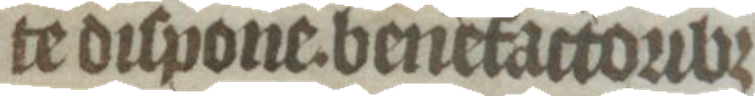

<font size="4">**Segmentation from sbb model with custon background constant**

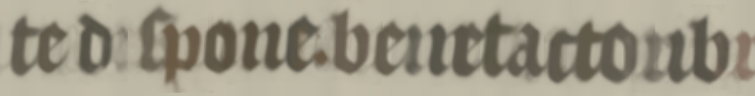

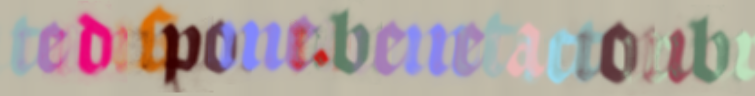

<font size="4">**Segmentation from sbb model with 0.5/0.5/0.5 background constant**

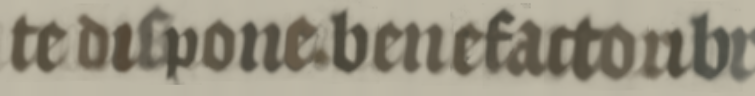

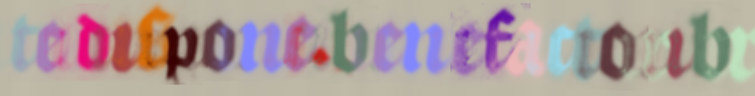

In [39]:
sbb_05_bg_loader = trainer_sbb_05_bg.train_loader
x_sbb_05_bg = get_line(sbb_05_bg_loader, index)
sbb_05_bg_decompositor = trainer_sbb_05_bg.decompositor
gt_sbb_05_bg, rec_sbb_05_bg, sgm_sbb_05_bg = inference_from_line(sbb_05_bg_decompositor, x_sbb_05_bg)

display(gt_sbb)
display(Markdown('<font size="4">**Segmentation from sbb model with custon background constant**'))
display(rec_sbb)
display(sgm_sbb)
display(Markdown('<font size="4">**Segmentation from sbb model with 0.5/0.5/0.5 background constant**'))
display(rec_sbb_05_bg)
display(sgm_sbb_05_bg)

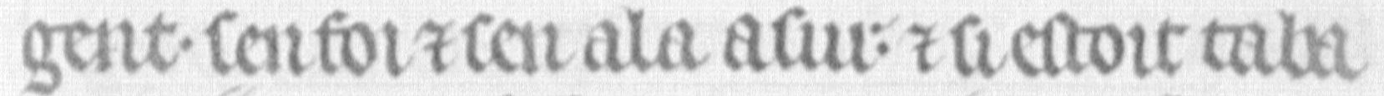

<font size="4">**Segmentation from textualis model with custon background constant**

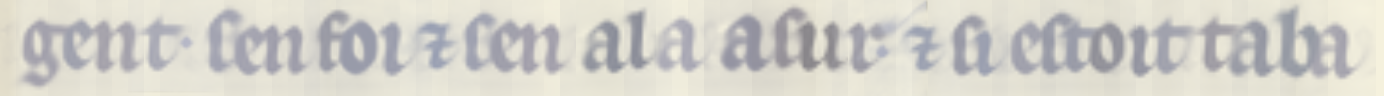

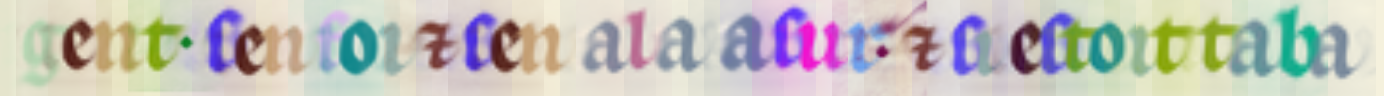

<font size="4">**Segmentation from textualis model with 0.5/0.5/0.5 background constant**

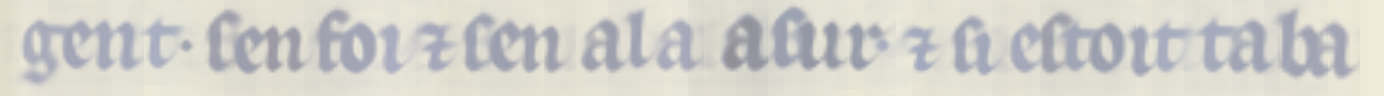

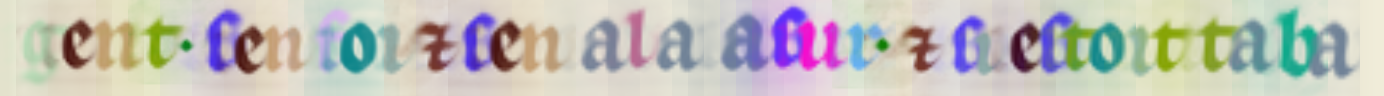

In [40]:
textualis_loader = trainer_textualis.train_loader
x_textualis = get_line(textualis_loader, index)
textualis_decompositor = trainer_textualis.decompositor
gt_textualis, rec_textualis, sgm_textualis = inference_from_line(textualis_decompositor, x_textualis)

textualis_05_bg_loader = trainer_textualis_05_bg.train_loader
x_textualis_05_bg = get_line(textualis_05_bg_loader, index)
textualis_05_bg_decompositor = trainer_textualis_05_bg.decompositor
gt_textualis_05_bg, rec_textualis_05_bg, sgm_textualis_05_bg = inference_from_line(textualis_05_bg_decompositor, x_textualis_05_bg)

display(gt_textualis)
display(Markdown('<font size="4">**Segmentation from textualis model with custom background constant**'))
display(rec_textualis)
display(sgm_textualis)
display(Markdown('<font size="4">**Segmentation from textualis model with 0.5/0.5/0.5 background constant**'))
display(rec_textualis_05_bg)
display(sgm_textualis_05_bg)

In [41]:
trainer_south_north_textualis

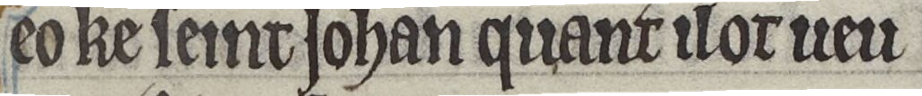

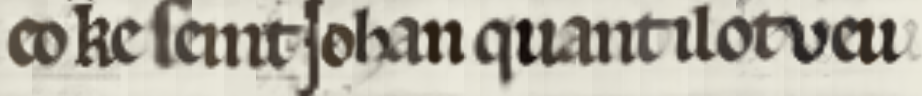

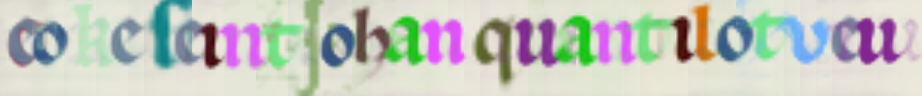

In [42]:
trainer_south_north_textualis_loader = trainer_south_north_textualis.train_loader
x_south_north_textualis = get_line(trainer_south_north_textualis_loader, index)
south_north_textualis_decompositor = trainer_south_north_textualis.decompositor
gt_south_north_textualis, rec_south_north_textualis, sgm_south_north_textualis = inference_from_line(south_north_textualis_decompositor, x_south_north_textualis)


display(gt_south_north_textualis)
display(rec_south_north_textualis)
display(sgm_south_north_textualis)